## Load and run a pretrained LSNN model with streaming microphone input
See the readme for instructions on training and train.py for the training script

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import queue
import sounddevice as sd
import tensorflow as tf
import tensorflow.compat.v1 as tf1
print('Tensorflow {}'.format(tf.__version__))

from models import create_lsnn_model
from spiking_models import KerasALIF, KerasDelayALIF
from threading import Thread
from time import time, sleep

Tensorflow 1.15.0


## Setup model parameters
This is a consolidated version of the model settings for train.py for readability.
Make sure that you train the LSNN with the same settings you use for inference.

In [3]:
model_dir = "results/speech_commands_train/"
model_checkpoint = "20200615-202035_lsnn_l1_h2048_w30.0str1.0_do0.0_b2.0_lif0.0_reg0.001_.ckpt-800"
labels = ["_silence_", "_unknown_", "yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
label_count = len(labels)

sample_rate = 16000
clip_duration_ms = 1000
window_size_ms = 30
window_stride_ms = 1
num_samples = int(sample_rate * clip_duration_ms / 1000)
window_size_samples = int(sample_rate * window_size_ms / 1000)
window_stride_samples = int(sample_rate * window_stride_ms / 1000)
length_minus_window = (num_samples - window_size_samples)
input_length = 1 + int(length_minus_window / window_stride_samples)
input_features = 40
input_size = input_features * input_length
log_noise_floor = 1e-12

model_settings = {
    'desired_samples': num_samples,
    'window_size_samples': window_size_samples,
    'window_stride_samples': window_stride_samples,
    'spectrogram_length': input_length,
    'fingerprint_width': input_features,
    'fingerprint_size': input_size,
    'label_count': label_count,
    'sample_rate': sample_rate,
    'preprocess': "mfcc",
    'average_window_width': -1,
    'in_repeat': 1,
    "n_hidden": 2048,
    "n_layer": 1,
    "dropout_prob": 0,
    "n_lif_frac": 0.0,
    "tau": 20,
    "refr": 2,
    "beta": 2.0,
    "n_thr_spikes": 1,
    "n_delay": 0,
    "eprop": False,
    "random_eprop": False,
    "avg_spikes": True,
}

## Create an input preprocessing graph (MFCCs only) and the model graph

In [4]:
tf1.reset_default_graph()

signal_input = tf1.placeholder(tf.float32, [num_samples, 1], name='signal')

def periodic_hann_window(window_length, dtype):
    wl = tf.cast(window_length, dtype=dtype)
    r = tf.range(wl, dtype=dtype)
    return 0.5 - 0.5 * tf.math.cos(2.0 * np.pi * r / wl)

signal_stft = tf.signal.stft(tf.transpose(signal_input, [1, 0]),
                             frame_length=model_settings['window_size_samples'],
                             frame_step=model_settings['window_stride_samples'],
                             window_fn=periodic_hann_window)

spectrograms = tf.abs(signal_stft)

num_spectrogram_bins = signal_stft.shape[-1]
mel_weights = tf.signal.linear_to_mel_weight_matrix(input_features, num_spectrogram_bins, sample_rate)
mel_spectrograms = tf.tensordot(spectrograms, mel_weights, 1)

log_mel_spectrograms = tf.math.log(mel_spectrograms + log_noise_floor)
signal_mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :input_features]

input_layer = tf.reshape(signal_mfccs, [1, -1])

logits, spikes, _ = create_lsnn_model(input_layer, model_settings, is_training=False)
softmax = tf.nn.softmax(logits)
average_spikes = tf.reduce_mean(spikes, axis=(0, 1))

saver = tf1.train.Saver()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Setup the sound device
Make sure to set the appropriate device from the list below.

In [20]:
print(sd.query_devices())

signal_queue = queue.Queue()
signal = np.zeros(num_samples)
recorded_samples = 0

# Callback for the sound device stream
def enqueue_signal(data, samples, time, status):
    signal_queue.put(data[:,0])

# Dequeuing function to run in an input thread
def roll_signal(max_samples):
    global signal_queue, signal, recorded_samples
    while recorded_samples < max_samples:
        try:
            data = signal_queue.get(timeout=0.001)
            signal = np.roll(signal, -data.size)
            signal[-data.size:] = data
            recorded_samples += data.size
        except queue.Empty:
            pass

sd.default.device = 7
sd.default.channels = 1
sd.default.samplerate = sample_rate

0 HDA Intel PCH: ALC1220 Analog (hw:0,0), ALSA (2 in, 6 out)
   1 HDA Intel PCH: ALC1220 Digital (hw:0,1), ALSA (0 in, 2 out)
   2 HDA Intel PCH: ALC1220 Alt Analog (hw:0,2), ALSA (2 in, 0 out)
   3 HDA NVidia: HDMI 0 (hw:1,3), ALSA (0 in, 8 out)
   4 HDA NVidia: HDMI 1 (hw:1,7), ALSA (0 in, 2 out)
   5 HDA NVidia: HDMI 2 (hw:1,8), ALSA (0 in, 8 out)
   6 HDA NVidia: HDMI 3 (hw:1,9), ALSA (0 in, 8 out)
*  7 Jabra SPEAK 410 USB: Audio (hw:2,0), ALSA (1 in, 2 out)
   8 sysdefault, ALSA (128 in, 128 out)
   9 front, ALSA (0 in, 6 out)
  10 surround21, ALSA (0 in, 128 out)
  11 surround40, ALSA (0 in, 6 out)
  12 surround41, ALSA (0 in, 128 out)
  13 surround50, ALSA (0 in, 128 out)
  14 surround51, ALSA (0 in, 6 out)
  15 surround71, ALSA (0 in, 6 out)
  16 iec958, ALSA (0 in, 2 out)
  17 spdif, ALSA (0 in, 2 out)
  18 pulse, ALSA (32 in, 32 out)
  19 dmix, ALSA (0 in, 2 out)
  20 default, ALSA (32 in, 32 out)


## Begin recording and iteratively applying the trained model

In [21]:
# Set the duration in seconds that you want to run the demo
duration = 10.0
max_samples = int(duration * sample_rate)

# Capture the softmax outputs of the model at each iteration
all_outputs = []
# Record the time at each iteration
times = []

with tf1.Session() as sess:
    saver.restore(sess, os.path.join(model_dir, model_checkpoint))
    
    with sd.InputStream(callback=enqueue_signal) as stream:
        
        print('Recording...\n')
        record_thread = Thread(target=roll_signal, args=(max_samples,))
        record_thread.start()

        previous_label = 0
        current_sample = 0
        while current_sample < max_samples:
            if current_sample < recorded_samples:
                frozen_signal = signal.copy()
                current_sample = recorded_samples
                output = sess.run(softmax, feed_dict={signal_input: frozen_signal.reshape(-1, 1)})
                all_outputs.append(output)
                current_label = np.argmax(output, axis=1)[0]
                if current_label != previous_label:
                    print(labels[current_label], end='...')
                    previous_label = current_label
                times.append(time())
            else:
                # If there's nothing more the classify right now, sleep for 1 ms.
                sleep(0.001)
        
        record_thread.join()

# Convert the outputs and times to more convenient representations
all_outputs = np.array(all_outputs).squeeze()
times = np.diff(times)
print()
print('Finished')

INFO:tensorflow:Restoring parameters from results/speech_commands_train/20200615-202035_lsnn_l1_h2048_w30.0str1.0_do0.0_b2.0_lif0.0_reg0.001_.ckpt-800
Recording...

down...stop...left...right...left...right...left...right...left...right...left...right...stop...
Finished


## Playback and visualize the results

INFO:tensorflow:Restoring parameters from results/speech_commands_train/20200615-202035_lsnn_l1_h2048_w30.0str1.0_do0.0_b2.0_lif0.0_reg0.001_.ckpt-800


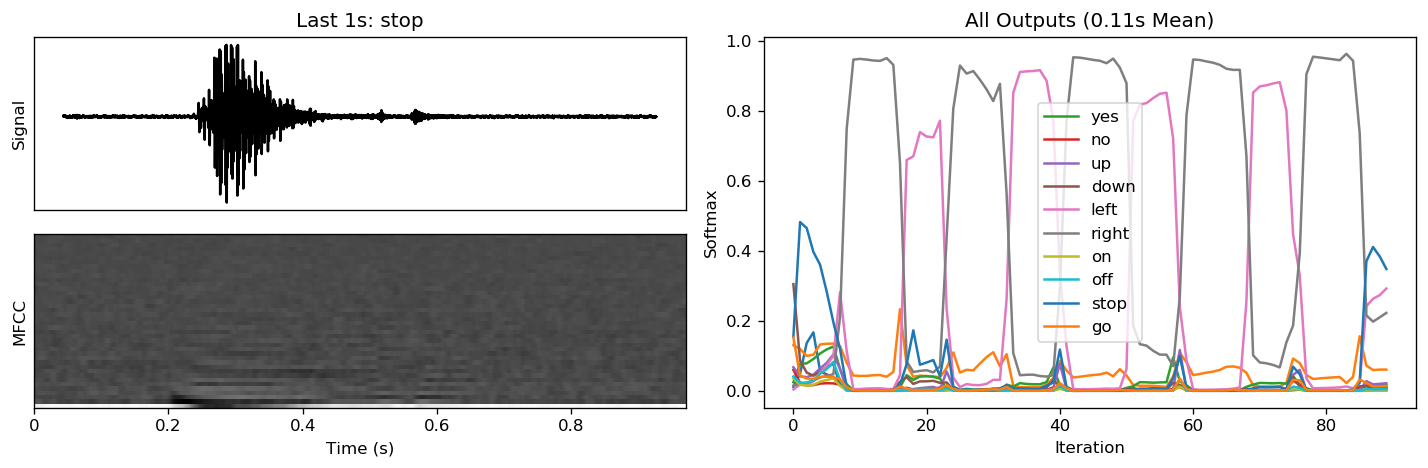

In [46]:
# Generate the MFCCs and final output
with tf1.Session() as sess:
    saver.restore(sess, os.path.join(model_dir, model_checkpoint))
    output, mfccs = sess.run([softmax, signal_mfccs], feed_dict={signal_input: signal.reshape(-1, 1)})
    predicted_class = labels[np.argmax(output)]

# Make sure to set a working output device
sd.play(signal, device=20, samplerate=sample_rate)

plt.figure(figsize=(12, 4), dpi=120)

# Plot the last second of signal recorded
plt.subplot(221)
plt.title('Last 1s: {}'.format(predicted_class))
plt.plot(signal, color='black')
plt.xticks([])
plt.ylabel('Signal')
plt.yticks([])

# Plot the MFCCs for the last second of signal
plt.subplot(223)
plt.imshow(mfccs[0].T, cmap=plt.cm.Greys, origin='bottomleft', aspect='auto')
plt.xticks([0, 200, 400, 600, 800], [0, 0.2, 0.4, 0.6, 0.8])
plt.xlabel('Time (s)')
plt.yticks([])
plt.ylabel('MFCC')

# Plot all the output node traces for every iteration of the model
plt.subplot(122)
plt.title('All Outputs ({:.2f}s Mean)'.format(times.mean()))
plt.plot(all_outputs)
plt.legend(labels)
plt.xlabel('Iteration')
plt.ylabel('Softmax')

plt.tight_layout()